In [1]:
# Import the usual libraries
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
#import matplotlib.patches as mpatches

# Enable inline plotting
%matplotlib inline

# Progress bar
from tqdm.auto import trange, tqdm

In [2]:
import os


from astropy.io import fits
import astropy.units as u

import pynrc
from pynrc import nrc_utils, DMS_input
# from pynrc import nrc_utils, nircam_cal, DMS_input, DetectorOps
# from pynrc.simul.apt import get_detname, get_timing_info, get_pointing_info, get_roll_info, get_tel_angles
# from pynrc.simul.skyvec2ins import skyvec2ins
# from pynrc.simul.ngNRC import create_level1b_FITS

# Import drop models and plot OPD routine
import webbpsf
from webbpsf_ext.opds import OTE_WFE_Drift_Model, plot_opd
from webbpsf_ext.maths import find_closest

pynrc.setup_logging('WARN', verbose=False)

In [3]:
pid_str = 'pid1194'

save_dir = f'/Users/jarron/NIRCam/Data/Sim_{pid_str}/'

# APT input files
apt_file_dir = '../../APT_output/'
json_file     = f'{apt_file_dir}{pid_str}.timing.json'
sm_acct_file  = f'{apt_file_dir}{pid_str}.smart_accounting'
pointing_file = f'{apt_file_dir}{pid_str}.pointing'
xml_file      = f'{apt_file_dir}{pid_str}.xml'

# Make sure files exist
for f in [json_file, sm_acct_file, pointing_file, xml_file]:
    print(f, os.path.isfile(f))

../../APT_output/pid1194.timing.json True
../../APT_output/pid1194.smart_accounting True
../../APT_output/pid1194.pointing True
../../APT_output/pid1194.xml True


In [4]:
# Create DMS Input class
obs_input = DMS_input(xml_file, pointing_file, json_file, sm_acct_file, save_dir=save_dir)

# # Update observing start date/time and V3 PA
obs_input.obs_date = '2022-11-04'
obs_input.obs_time = '12:00:00'
obs_input.pa_v3 = None

# Generate all observation parameters for every visit, exposure, detector, etc
obs_params_all = obs_input.gen_all_obs_params()
obs_params_all = np.asarray(obs_params_all)

Obs Params:   0%|          | 0/70 [00:00<?, ?it/s]

In [10]:
# iec_period=300
# slew_init=5
# case='BOL'
def gen_wfe_drift(obs_input, case='BOL', iec_period=300, slew_init=10, rand_seed=None, plot=False):
    """
    
    iec_period : float
        IEC heater switching period in seconds.
    """
    
    def plot_wfe():

        # Plot
        fig, axes = plt.subplots(2,1, figsize=(12,8), sharex=True)
        axes = axes.flatten()

        tunit = 'hr'
        tvals = t_all.to(tunit)

        ax = axes[0]
        ax.plot(tvals.value, slew_angles, marker='.')
        ax.set_ylabel('Pitch Angle (deg)')
        ax.set_title(f'OPD w/ Initial Slew of 5 deg (PID 1194, {case})')

        ylims = ax.get_ylim()
        dy = ylims[1]-ylims[0]

        for i, texp in enumerate(exp_start):
            t = (texp * u.s).to(tunit).value
            label = 'NRC Exps' if i==0 else None
            ax.plot([t,t], [ylims[0],ylims[0]+0.25*dy] , color='k', ls=':', lw=1, alpha=0.5, label=label)
        for i, tvisit in enumerate(visit_start):
            t = (tvisit * u.s).to(tunit).value
            label = 'Visit Start' if i==0 else None
            ax.plot([t,t], [ylims[0],ylims[0]+0.5*dy] , color='C2', ls='--', lw=1.5, label=label)
        for i, tslew in enumerate(slew_start):
            t = (tslew * u.s).to(tunit).value
            label = 'Slew Start' if i==0 else None
            ax.plot([t,t], [ylims[0],ylims[0]+0.75*dy] , color='C1', ls='--', lw=2, label=label)
            
        ax.set_ylim(ylims)
        ax.legend()

        # Plot WFE drift components
        # Offset relative to first visit in sequence
        wfe_dict2 = wfe_dict.copy()
        keys = list(wfe_dict.keys())#[0:2]
        for k in ['frill', 'thermal']:
            wfe_val = wfe_dict[k]
            trel = (visit_start[0]*u.s).to(tunit).value
            wfe_dict2[k] = wfe_val - np.interp(trel, tvals.value, wfe_val)
        # Update total RMS
        wfe_dict2['total'] = np.sqrt(wfe_dict2['frill']**2 + wfe_dict2['thermal']**2 + wfe_dict2['iec']**2)

        ax = axes[1]
        for k in ['frill', 'thermal', 'iec', 'total']:
            lw = 2 if 'total' in k else 1
            alpha = 0.5 if 'total' in k else 1
            ax.plot(tvals.value, wfe_dict2[k], label=k, lw=lw, alpha=alpha)
        ax.set_xlabel(f'Time ({tunit})')
            
        for ax in axes[1:]:
            ax.legend()
            ax.set_ylabel('$\Delta$WFE (nm RMS)')

        xlim = [-1,18.5]
        ax.set_xlim(xlim)
        ylim = ax.get_ylim()
        if np.abs(ylim[0])>ylim[1]:
            ylim = np.array([-1,1]) * np.max(np.abs(ylim))
        ax.set_ylim(ylim)
            
        fig.tight_layout()
    
    # Get total time for program
    temp, _, _, _ = obs_input.gen_pitch_array(nvals=1000)
    total_time = temp.max()

    # Create a series of time values to evolve over
    dt = iec_period / 2 # Timing sample
    tarr = np.arange(0, total_time, dt) # seconds

    # Required size
    nvals = len(tarr)

    # Create an initial fake scenario to occur before ours
    res = obs_input.gen_pitch_array(nvals=nvals, pitch_init=None)
    tprior, pitch_prior, _, _ = res
    tprior = tprior[::5] - tprior[-1]
    pitch_prior = pitch_prior[::5][::-1] - slew_init
    pitch_prior[0] -= slew_init

    # Create desired observations
    res = obs_input.gen_pitch_array(nvals=nvals, pitch_init=pitch_prior[-1])
    tarr, pitch_arr, slew_start, visit_start = res

    # Change anything that's outside of pitch bounds
    pitch_prior[pitch_prior<-5] = -5
    pitch_prior[pitch_prior>45] = 45
    pitch_arr[pitch_arr<-5] = -5
    pitch_arr[pitch_arr>45] = 45

    # All NIRCam exposure start times
    exp_start = []
    for k in obs_input.program_info.keys():
        d = obs_input.program_info[k]
        exp_start.append(d['exp_start_times'])
    exp_start = np.concatenate(exp_start)

    webbpsf_path = webbpsf.utils.get_webbpsf_data_path()
    pupil_file = 'jwst_pupil_RevW_npix1024.fits.gz'
    opd_file = 'OPD_RevW_ote_for_NIRCam_requirements.fits.gz'

    pupil_path = os.path.join(webbpsf_path, pupil_file)
    opd_path = os.path.join(webbpsf_path, 'NIRCam', 'OPD', opd_file)

    name = "Modified OPD from " + str(opd_file)

    # Initiate OTE drift class
    ote = OTE_WFE_Drift_Model(name=name, opd=opd_path, transmission=pupil_path)

    # Generate delta OPDs for each time step
    # Also outputs a dictionary of each component's WFE drift value (nm RMS)
    t_all = np.concatenate([tprior, tarr]) * u.s
    slew_angles = np.concatenate([pitch_prior, pitch_arr])

    wfe_dict_all = ote.evolve_dopd(t_all, slew_angles, case=case, 
                                   return_dopd_fin=False, random_seed=rand_seed)

    tunit = 'hr'
    tvals = t_all.to(tunit)

    # Offset relative to first visit in sequence
    wfe_dict = wfe_dict_all.copy()
    keys = list(wfe_dict_all.keys())#[0:2]
    for k in ['frill', 'thermal']:
        wfe_val = wfe_dict[k]
        trel = (visit_start[0]*u.s).to(tunit).value
        wfe_dict[k] = wfe_val - np.interp(trel, tvals.value, wfe_val)
    # Update total RMS
    wfe_dict['total'] = np.sqrt(wfe_dict['frill']**2 + wfe_dict['thermal']**2 + wfe_dict['iec']**2)

    wfe_dict['time'] = tvals
    
    if plot:
        plot_wfe()
    
    return wfe_dict

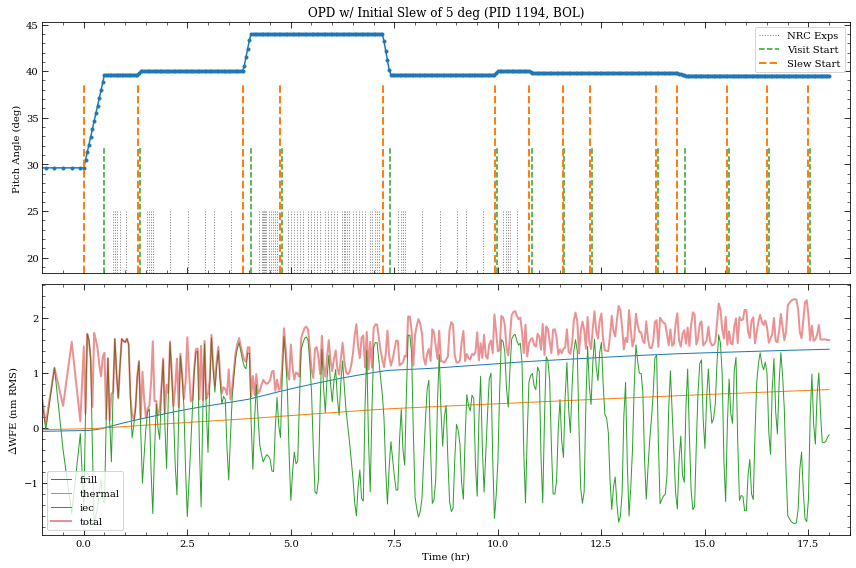

In [15]:
wfe_dict = gen_wfe_drift(obs_input, slew_init=10, rand_seed=1, plot=True)

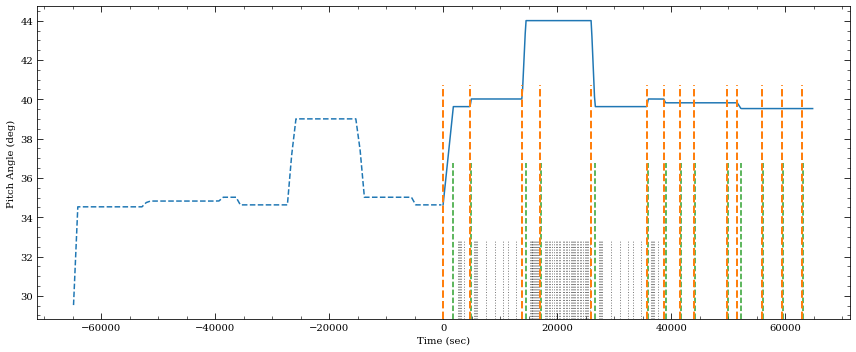

In [6]:
fig, ax = plt.subplots(1,1, figsize=(12,5))

ax.plot(tprior, pitch_prior, color='C0', ls='--')
ax.plot(tarr, pitch_arr, color='C0')

ylims = ax.get_ylim()
dy = ylims[1]-ylims[0]

for texp in exp_start:
    ax.plot([texp,texp], [ylims[0],ylims[0]+0.25*dy] , color='k', ls=':', lw=1, alpha=0.5)
for tvisit in visit_start:
    ax.plot([tvisit,tvisit], [ylims[0],ylims[0]+0.5*dy] , color='C2', ls='--', lw=1.5)
for tslew in slew_start:
    ax.plot([tslew,tslew], [ylims[0],ylims[0]+0.75*dy] , color='C1', ls='--', lw=2)

ax.set_ylim(ylims)
ax.set_ylabel('Pitch Angle (deg)')
ax.set_xlabel('Time (sec)')

fig.tight_layout()

In [7]:
webbpsf_path = webbpsf.utils.get_webbpsf_data_path()
pupil_file = 'jwst_pupil_RevW_npix1024.fits.gz'
opd_file = 'OPD_RevW_ote_for_NIRCam_requirements.fits.gz'

pupil_path = os.path.join(webbpsf_path, pupil_file)
opd_path = os.path.join(webbpsf_path, 'NIRCam', 'OPD', opd_file)

name = "Modified OPD from " + str(opd_file)

# Initiate OTE drift class
ote = OTE_WFE_Drift_Model(name=name, opd=opd_path, transmission=pupil_path)

In [8]:
# Generate delta OPDs for each time step
# Also outputs a dictionary of each component's WFE drift value (nm RMS)
t_all = np.concatenate([tprior, tarr]) * u.s
slew_angles = np.concatenate([pitch_prior, pitch_arr])
case = 'BOL'

wfe_dict = ote.evolve_dopd(t_all, slew_angles, case=case, return_dopd_fin=False)

Slews:   0%|          | 0/48 [00:00<?, ?it/s]

In [11]:
# Generate delta OPDs for each time step
# Also outputs a dictionary of each component's WFE drift value (nm RMS)
t_all = np.concatenate([tprior, tarr]) * u.s
slew_angles = np.concatenate([pitch_prior, pitch_arr])
case = 'BOL'

wfe_dict = ote.evolve_dopd(t_all, slew_angles, case=case, return_dopd_fin=False)

Slews:   0%|          | 0/48 [00:00<?, ?it/s]

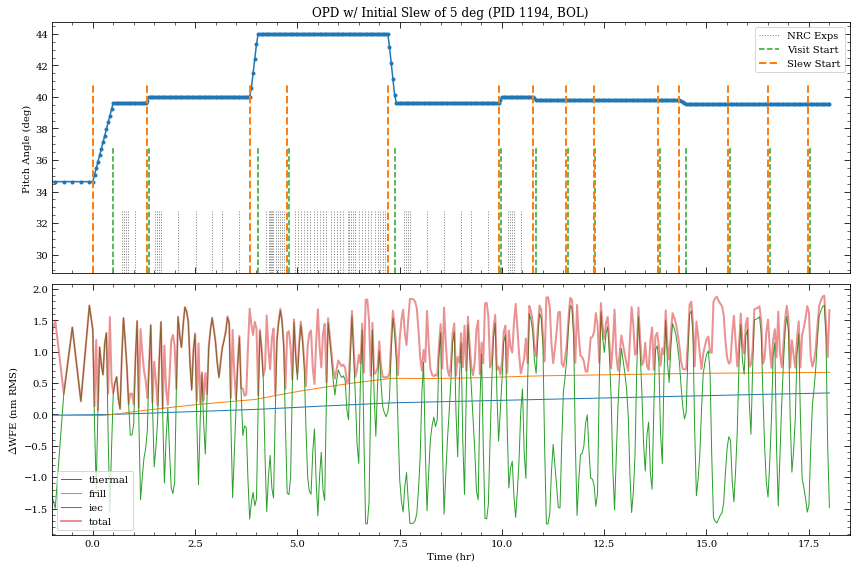

In [10]:
# Plot
fig, axes = plt.subplots(2,1, figsize=(12,8), sharex=True)
axes = axes.flatten()

tunit = 'hr'
tvals = t_all.to(tunit)

ax = axes[0]
ax.plot(tvals.value, slew_angles, marker='.')
ax.set_ylabel('Pitch Angle (deg)')
ax.set_title(f'OPD w/ Initial Slew of 5 deg (PID 1194, {case})')

ylims = ax.get_ylim()
dy = ylims[1]-ylims[0]

for i, texp in enumerate(exp_start):
    t = (texp * u.s).to(tunit).value
    label = 'NRC Exps' if i==0 else None
    ax.plot([t,t], [ylims[0],ylims[0]+0.25*dy] , color='k', ls=':', lw=1, alpha=0.5, label=label)
for i, tvisit in enumerate(visit_start):
    t = (tvisit * u.s).to(tunit).value
    label = 'Visit Start' if i==0 else None
    ax.plot([t,t], [ylims[0],ylims[0]+0.5*dy] , color='C2', ls='--', lw=1.5, label=label)
for i, tslew in enumerate(slew_start):
    t = (tslew * u.s).to(tunit).value
    label = 'Slew Start' if i==0 else None
    ax.plot([t,t], [ylims[0],ylims[0]+0.75*dy] , color='C1', ls='--', lw=2, label=label)
    
ax.set_ylim(ylims)
ax.legend()

# Plot WFE drift components
# Offset relative to first visit in sequence
wfe_dict2 = wfe_dict.copy()
keys = list(wfe_dict.keys())#[0:2]
for k in ['frill', 'thermal']:
    wfe_val = wfe_dict[k]
    trel = (visit_start[0]*u.s).to(tunit).value
    wfe_dict2[k] = wfe_val - np.interp(trel, tvals.value, wfe_val)
# Update total RMS
wfe_dict2['total'] = np.sqrt(wfe_dict2['frill']**2 + wfe_dict2['thermal']**2 + wfe_dict2['iec']**2)

ax = axes[1]
for k in keys:
    lw = 2 if 'total' in k else 1
    alpha = 0.5 if 'total' in k else 1
    ax.plot(tvals.value, wfe_dict2[k], label=k, lw=lw, alpha=alpha)
ax.set_xlabel(f'Time ({tunit})')
    
for ax in axes[1:]:
    ax.legend()
    ax.set_ylabel('$\Delta$WFE (nm RMS)')

xlim = [-1,18.5]
ax.set_xlim(xlim)
ylim = ax.get_ylim()
if np.abs(ylim[0])>ylim[1]:
    ylim = np.array([-1,1]) * np.max(np.abs(ylim))
ax.set_ylim(ylim)
    
fig.tight_layout()

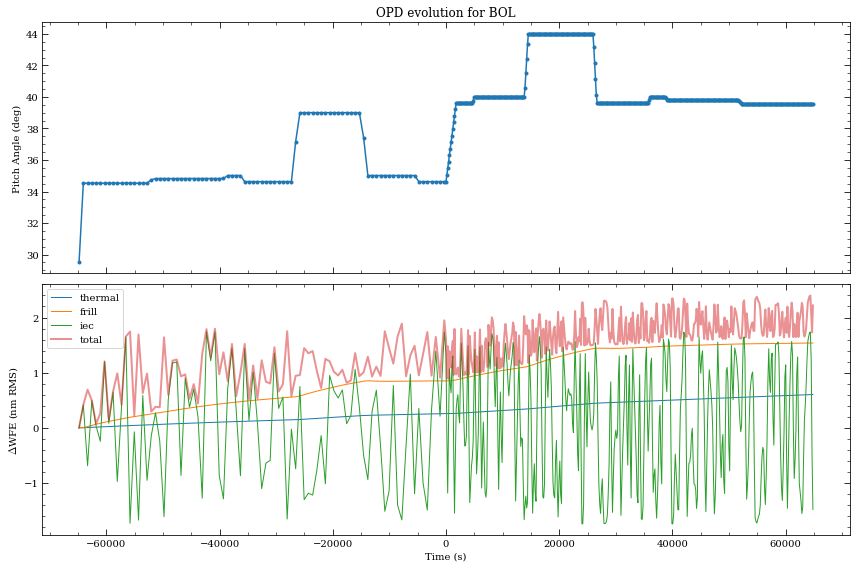

In [11]:
# Plot
fig, axes = plt.subplots(2,1, figsize=(12,8), sharex=True)
axes = axes.flatten()

ax = axes[0]
ax.plot(t_all.value, slew_angles, marker='.')
ax.set_ylabel('Pitch Angle (deg)')
ax.set_title(f'OPD evolution for {case}')

ax = axes[1]
keys = list(wfe_dict.keys())
for k in keys:
    lw = 2 if 'total' in k else 1
    alpha = 0.5 if 'total' in k else 1
    ax.plot(t_all.value, wfe_dict[k], label=k, lw=lw, alpha=alpha)
ax.set_xlabel(f'Time ({t_all.unit})')
    
for ax in axes[1:]:
    ax.legend()
    ax.set_ylabel('$\Delta$WFE (nm RMS)')

fig.tight_layout()